## Directional Coupler and Geometry Objects from GDSII File

The directional coupler as well as the source and mode monitor geometries are described by the GDSII file [examples/coupler.gds](https://github.com/NanoComp/meep/blob/master/python/examples/coupler.gds). A snapshot of this file viewed using [KLayout](https://www.klayout.de/) is shown below. The figure labels have been added in post processing. The design consists of two identical strip waveguides which are positioned close together via an adiabatic taper such that their modes couple evanescently. There is a source (labelled "Source") and four mode monitors (labelled "Port 1", etc.). The input pulse from Port 1 is split in two and exits through Ports 3 and 4. The design objective is to find the separation distance (labelled "d") which maximizes power in Port 4 at a wavelength of 1.55 μm. More generally, though not included in this example, it is possible to have two additional degrees of freedom: (1) the length of the straight waveguide section where the two waveguides are coupled and (2) the length of the tapered section (the taper profile is described by a hyperbolic tangent (tanh) function).

![](https://meep.readthedocs.io/en/latest/images/klayout_schematic.png)

The GDSII file is adapted from the [SiEPIC EBeam PDK](https://github.com/lukasc-ubc/SiEPIC_EBeam_PDK) with four major modifications:

+ the computational cell is centered at the origin of the *xy* plane and defined on layer 0

+ the source and four mode monitors are defined on layers 1-5

+ the lower and upper branches of the coupler are defined on layers 31 and 32

+ the straight waveguide sections are perfectly linear

Note that rather than being specified as part of the GDSII file, the volume regions of the source and flux monitors could have been specified in the simulation script.

In [1]:
import meep as mp
import numpy
import matplotlib.pyplot as plt

res = 25  # pixels/μm
three_d = False  # 3d calculation?
d = 0.12  # branch separation

gdsII_file = "coupler.gds"
CELL_LAYER = 0
PORT1_LAYER = 1
PORT2_LAYER = 2
PORT3_LAYER = 3
PORT4_LAYER = 4
SOURCE_LAYER = 5
UPPER_BRANCH_LAYER = 31
LOWER_BRANCH_LAYER = 32
default_d = 0.3

t_oxide = 1.0
t_Si = 0.22
t_air = 0.78

dpml = 1
cell_thickness = dpml + t_oxide + t_Si + t_air + dpml

oxide = mp.Medium(epsilon=2.25)
silicon = mp.Medium(epsilon=12)

lcen = 1.55
fcen = 1 / lcen
df = 0.2 * fcen

cell_zmax = 0.5 * cell_thickness if three_d else 0
cell_zmin = -0.5 * cell_thickness if three_d else 0
si_zmax = 0.5 * t_Si if three_d else 10
si_zmin = -0.5 * t_Si if three_d else -10

# read cell size, volumes for source region and flux monitors,
# and coupler geometry from GDSII file
upper_branch = mp.get_GDSII_prisms(
    silicon, gdsII_file, UPPER_BRANCH_LAYER, si_zmin, si_zmax
)
lower_branch = mp.get_GDSII_prisms(
    silicon, gdsII_file, LOWER_BRANCH_LAYER, si_zmin, si_zmax
)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
p1 = mp.GDSII_vol(gdsII_file, PORT1_LAYER, si_zmin, si_zmax)
p2 = mp.GDSII_vol(gdsII_file, PORT2_LAYER, si_zmin, si_zmax)
p3 = mp.GDSII_vol(gdsII_file, PORT3_LAYER, si_zmin, si_zmax)
p4 = mp.GDSII_vol(gdsII_file, PORT4_LAYER, si_zmin, si_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)

# displace upper and lower branches of coupler (as well as source and flux regions)
if d != default_d:
    delta_y = 0.5 * (d - default_d)
    delta = mp.Vector3(y=delta_y)
    p1.center += delta
    p2.center -= delta
    p3.center += delta
    p4.center -= delta
    src_vol.center += delta
    cell.size += 2 * delta
    for np in range(len(lower_branch)):
        lower_branch[np].center -= delta
        for nv in range(len(lower_branch[np].vertices)):
            lower_branch[np].vertices[nv] -= delta
    for np in range(len(upper_branch)):
        upper_branch[np].center += delta
        for nv in range(len(upper_branch[np].vertices)):
            upper_branch[np].vertices[nv] += delta

geometry = upper_branch + lower_branch

if three_d:
    oxide_center = mp.Vector3(z=-0.5 * t_oxide)
    oxide_size = mp.Vector3(cell.size.x, cell.size.y, t_oxide)
    oxide_layer = [mp.Block(material=oxide, center=oxide_center, size=oxide_size)]
    geometry = geometry + oxide_layer

sources = [
    mp.EigenModeSource(
        src=mp.GaussianSource(fcen, fwidth=df),
        size=src_vol.size,
        center=src_vol.center,
        eig_band=1,
        eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
    )
]

sim = mp.Simulation(
    resolution=res,
    cell_size=cell.size,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
    geometry=geometry,
)

mode1 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p1))
mode2 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p2))
mode3 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p3))
mode4 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p4))

sim.run(until_after_sources=100)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000570059 s
Working in 2D dimensions.
Computational cell is 34.4 x 7.84 x 0 with resolution 25
     prism, center = (-9.09425,1.32149,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 174 vertices:
          (-4,0.06,-10)
          (-4.108,0.061,-10)
          (-4.215,0.062,-10)
          (-4.322,0.065,-10)
          (-4.429,0.07,-10)
          (-4.535,0.075,-10)
          (-4.641,0.081,-10)
          (-4.747,0.089,-10)
          (-4.852,0.097,-10)
          (-5.062,0.117,-10)
          (-5.167,0.129,-10)
          (-5.271,0.141,-10)
          (-5.479,0.169,-10)
          (-5.582,0.184,-10)
          (-5.685,0.2,-10)
          (-5.788,0.217,-10)
          (-5.891,0.235,-10)
          (-5.993,0.253,-10)
          (-6.095,0.272,-10)
          (-6.197,0.292,-10)
          (-6.299,0.313,-10)
          (-6.4,0.334,-10)
          (-6.501,0.356,-10)
          (-6.703,0.402,-10)
          (-6.803,0.425,-10)


          (13.19,2.025,-10)
          (12.99,2.005,-10)
          (12.89,1.994,-10)
          (12.791,1.982,-10)
          (12.691,1.97,-10)
          (12.592,1.956,-10)
          (12.394,1.926,-10)
          (12.295,1.91,-10)
          (12.196,1.893,-10)
          (12.098,1.875,-10)
          (11.999,1.856,-10)
          (11.901,1.837,-10)
          (11.802,1.817,-10)
          (11.704,1.797,-10)
          (11.606,1.776,-10)
          (11.508,1.754,-10)
          (11.41,1.731,-10)
          (11.313,1.708,-10)
          (11.215,1.685,-10)
          (11.117,1.66,-10)
          (11.02,1.636,-10)
          (10.922,1.611,-10)
          (10.728,1.559,-10)
          (10.63,1.533,-10)
          (10.533,1.506,-10)
          (10.436,1.478,-10)
          (10.338,1.451,-10)
          (10.144,1.395,-10)
          (10.047,1.366,-10)
          (9.949,1.337,-10)
          (9.658,1.25,-10)
          (9.56,1.22,-10)
          (9.463,1.191,-10)
          (9.366,1.161,-10)
          (9.268,1.131,-10)
   

          (13.359,-2.539,-10)
          (13.253,-2.531,-10)
          (13.148,-2.523,-10)
          (12.938,-2.503,-10)
          (12.833,-2.491,-10)
          (12.729,-2.479,-10)
          (12.521,-2.451,-10)
          (12.418,-2.436,-10)
          (12.315,-2.42,-10)
          (12.212,-2.403,-10)
          (12.109,-2.385,-10)
          (12.007,-2.367,-10)
          (11.905,-2.348,-10)
          (11.803,-2.328,-10)
          (11.701,-2.307,-10)
          (11.6,-2.286,-10)
          (11.499,-2.264,-10)
          (11.297,-2.218,-10)
          (11.197,-2.195,-10)
          (11.096,-2.17,-10)
          (10.796,-2.095,-10)
          (10.697,-2.068,-10)
          (10.597,-2.042,-10)
          (10.498,-2.015,-10)
          (10.399,-1.987,-10)
          (10.3,-1.96,-10)
          (10.201,-1.932,-10)
          (10.102,-1.903,-10)
          (10.004,-1.875,-10)
          (9.905,-1.846,-10)
          (9.807,-1.817,-10)
          (9.709,-1.787,-10)
          (9.611,-1.758,-10)
          (9.513,-1.7

subpixel-averaging is 75.8697% done, 1.34937 s remaining
subpixel-averaging is 79.2797% done, 1.08291 s remaining
subpixel-averaging is 82.6896% done, 0.888016 s remaining
subpixel-averaging is 86.0995% done, 0.710327 s remaining
subpixel-averaging is 89.5094% done, 0.493508 s remaining
subpixel-averaging is 92.9193% done, 0.332601 s remaining
subpixel-averaging is 98.8867% done, 0.0488103 s remaining
time for set_epsilon = 271.702 s
-----------
MPB solved for frequency_1(2.2349,0,0) = 0.687238 after 22 iters
MPB solved for frequency_1(2.08443,0,0) = 0.645247 after 8 iters
MPB solved for frequency_1(2.08412,0,0) = 0.645161 after 3 iters
MPB solved for frequency_1(2.08412,0,0) = 0.645161 after 1 iters


FloatProgress(value=0.0, description='0% done ', max=177.5)

Meep progress: 44.68/177.5 = 25.2% done in 4.0s, 11.9s to go
on time step 2239 (time=44.78), 0.00178698 s/step
Meep progress: 93.64/177.5 = 52.8% done in 8.0s, 7.2s to go
on time step 4687 (time=93.74), 0.00163464 s/step
Meep progress: 142.64000000000001/177.5 = 80.4% done in 12.0s, 2.9s to go
on time step 7139 (time=142.78), 0.00163171 s/step
run 0 finished at t = 177.5 (8875 timesteps)


In [2]:
# S parameters
p1_coeff = sim.get_eigenmode_coefficients(
    mode1, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z
).alpha[0, 0, 0]
p2_coeff = sim.get_eigenmode_coefficients(
    mode2, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z
).alpha[0, 0, 1]
p3_coeff = sim.get_eigenmode_coefficients(
    mode3, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z
).alpha[0, 0, 0]
p4_coeff = sim.get_eigenmode_coefficients(
    mode4, [1], eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y + mp.ODD_Z
).alpha[0, 0, 0]

# transmittance
p2_trans = abs(p2_coeff) ** 2 / abs(p1_coeff) ** 2
p3_trans = abs(p3_coeff) ** 2 / abs(p1_coeff) ** 2
p4_trans = abs(p4_coeff) ** 2 / abs(p1_coeff) ** 2

print("trans:, {:.2f}, {:.6f}, {:.6f}, {:.6f}".format(d, p2_trans, p3_trans, p4_trans))

MPB solved for frequency_1(2.2349,0,0) = 0.687243 after 22 iters
MPB solved for frequency_1(2.08451,0,0) = 0.64527 after 5 iters
MPB solved for frequency_1(2.08412,0,0) = 0.645161 after 4 iters
MPB solved for frequency_1(2.08412,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.084124,-0.000000,0.000000)
MPB solved for frequency_1(2.2349,0,0) = 0.687243 after 12 iters
MPB solved for frequency_1(2.08452,0,0) = 0.645271 after 5 iters
MPB solved for frequency_1(2.08413,0,0) = 0.645161 after 3 iters
MPB solved for frequency_1(2.08413,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.084127,-0.000000,0.000000)
MPB solved for frequency_1(2.2349,0,0) = 0.687236 after 8 iters
MPB solved for frequency_1(2.08441,0,0) = 0.645241 after 8 iters
MPB solved for frequency_1(2.08412,0,0) = 0.645161 after 3 iters
MPB solved for frequency_1(2.08412,0,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (2.084118,-0.000000,0.000000)
MPB solved for frequency_1(2.2349,0,0) 

For a given waveguide separation distance (`d`), the simulation computes the transmittance of Ports 2, 3, and 4. The transmittance is the square of the [S-parameter](https://en.wikipedia.org/wiki/Scattering_parameters) which is equivalent to the [mode coefficient](https://meep.readthedocs.io/en/latest/Mode_Decomposition). There is an additional mode monitor at Port 1 to compute the input power from the adjacent eigenmode source; this is used for normalization when computing the transmittance. The eight layers of the GDSII file are each converted to a `Simulation` object: the upper and lower branches of the coupler are defined as a collection of [`Prism`](https://meep.readthedocs.io/en/latest/Python_User_Interface/#prism)s, the rectilinear regions of the source and flux monitor as a [`Volume`](https://meep.readthedocs.io/en/latest/Python_User_Interface/#volume) and [`FluxRegion`](https://meep.readthedocs.io/en/latest/Python_User_Interface/#fluxregion). The size of the cell in the $y$ direction is dependent on `d`. The default dimensionality is 2d. (Note that for a 2d cell the `Prism` objects returned by `get_GDSII_prisms` must have a finite height. The finite height of `Volume` objects returned by `GDSII_vol` are ignored in 2d.) An optional input parameter (`three_d`) converts the geometry to 3d by extruding the coupler geometry in the *z* direction and adding an oxide layer beneath similar to a [silicon on insulator](https://en.wikipedia.org/wiki/Silicon_on_insulator) (SOI) substrate. A schematic of the coupler design in 3d generated using MayaVi is shown below.

![](https://meep.readthedocs.io/en/latest/images/coupler3D.png)


## Transmittance Results and Field Profiles

The transmittance results are plotted in the figure below for a range of separation distances from 0.02 to 0.30 μm with increments of 0.02 μm. When the two waveguide branches are sufficiently separated (`d` > 0.2 μm), practically all of the input power remains in the top branch and is transferred to Port 3. A small amount of the input power is lost due to scattering into radiative modes within the light cone in the tapered sections where the translational symmetry of the waveguide is broken. This is why the power in Port 3 never reaches exactly 100%. For separation distances of less than approximately 0.2 μm, evanescent coupling of the modes from the top to the lower branch begins to transfer some of the input power to Port 4. For `d` of 0.13 μm, the input signal is split evenly into Ports 3 and 4. For `d` of 0.06 μm, the input power is transferred completely to Port 4. Finally, for `d` of less than 0.06 μm, the evanescent coupling becomes rapidly ineffective and the signal again remains mostly in Port 3. Note that there is never any power in Port 2 given its location relative to the input from Port 1.

![](https://meep.readthedocs.io/en/latest/images/directional_coupler_flux.png)

These quantitative results can also be verified qualitatively using the field profiles shown below for `d` of 0.06, 0.13, and 0.30 μm. To generate these images, the pulse source is replaced with a [continuous wave](https://meep.readthedocs.io/en/latest/Python_User_Interface/#continuoussource) (CW) and the fields are time stepped for a sufficiently long run time until they have reached steady state. The [array slicing](https://meep.readthedocs.io/en/latest/Python_User_Interface/#array-slices) routines `get_epsilon` and `get_efield_z` are then used to obtain the dielectric and field data over the entire cell.

-----------
Initializing structure...
time for choose_chunkdivision = 0.000232935 s
Working in 2D dimensions.
Computational cell is 34.4 x 7.84 x 0 with resolution 25
     prism, center = (-9.09425,1.32149,0)
          height 20, axis (0,0,1), sidewall angle: 0 radians, 174 vertices:
          (-4,0.06,-10)
          (-4.108,0.061,-10)
          (-4.215,0.062,-10)
          (-4.322,0.065,-10)
          (-4.429,0.07,-10)
          (-4.535,0.075,-10)
          (-4.641,0.081,-10)
          (-4.747,0.089,-10)
          (-4.852,0.097,-10)
          (-5.062,0.117,-10)
          (-5.167,0.129,-10)
          (-5.271,0.141,-10)
          (-5.479,0.169,-10)
          (-5.582,0.184,-10)
          (-5.685,0.2,-10)
          (-5.788,0.217,-10)
          (-5.891,0.235,-10)
          (-5.993,0.253,-10)
          (-6.095,0.272,-10)
          (-6.197,0.292,-10)
          (-6.299,0.313,-10)
          (-6.4,0.334,-10)
          (-6.501,0.356,-10)
          (-6.703,0.402,-10)
          (-6.803,0.425,-10)


          (13.19,2.025,-10)
          (12.99,2.005,-10)
          (12.89,1.994,-10)
          (12.791,1.982,-10)
          (12.691,1.97,-10)
          (12.592,1.956,-10)
          (12.394,1.926,-10)
          (12.295,1.91,-10)
          (12.196,1.893,-10)
          (12.098,1.875,-10)
          (11.999,1.856,-10)
          (11.901,1.837,-10)
          (11.802,1.817,-10)
          (11.704,1.797,-10)
          (11.606,1.776,-10)
          (11.508,1.754,-10)
          (11.41,1.731,-10)
          (11.313,1.708,-10)
          (11.215,1.685,-10)
          (11.117,1.66,-10)
          (11.02,1.636,-10)
          (10.922,1.611,-10)
          (10.728,1.559,-10)
          (10.63,1.533,-10)
          (10.533,1.506,-10)
          (10.436,1.478,-10)
          (10.338,1.451,-10)
          (10.144,1.395,-10)
          (10.047,1.366,-10)
          (9.949,1.337,-10)
          (9.658,1.25,-10)
          (9.56,1.22,-10)
          (9.463,1.191,-10)
          (9.366,1.161,-10)
          (9.268,1.131,-10)
   

          (13.359,-2.539,-10)
          (13.253,-2.531,-10)
          (13.148,-2.523,-10)
          (12.938,-2.503,-10)
          (12.833,-2.491,-10)
          (12.729,-2.479,-10)
          (12.521,-2.451,-10)
          (12.418,-2.436,-10)
          (12.315,-2.42,-10)
          (12.212,-2.403,-10)
          (12.109,-2.385,-10)
          (12.007,-2.367,-10)
          (11.905,-2.348,-10)
          (11.803,-2.328,-10)
          (11.701,-2.307,-10)
          (11.6,-2.286,-10)
          (11.499,-2.264,-10)
          (11.297,-2.218,-10)
          (11.197,-2.195,-10)
          (11.096,-2.17,-10)
          (10.796,-2.095,-10)
          (10.697,-2.068,-10)
          (10.597,-2.042,-10)
          (10.498,-2.015,-10)
          (10.399,-1.987,-10)
          (10.3,-1.96,-10)
          (10.201,-1.932,-10)
          (10.102,-1.903,-10)
          (10.004,-1.875,-10)
          (9.905,-1.846,-10)
          (9.807,-1.817,-10)
          (9.709,-1.787,-10)
          (9.611,-1.758,-10)
          (9.513,-1.7

subpixel-averaging is 75.8697% done, 1.34979 s remaining
subpixel-averaging is 79.2797% done, 1.08361 s remaining
subpixel-averaging is 82.6896% done, 0.888317 s remaining
subpixel-averaging is 86.0995% done, 0.711677 s remaining
subpixel-averaging is 89.5094% done, 0.492528 s remaining
subpixel-averaging is 92.9193% done, 0.332357 s remaining
subpixel-averaging is 98.8867% done, 0.0488405 s remaining
time for set_epsilon = 271.364 s
-----------
MPB solved for frequency_1(2.2349,0,0) = 0.687243 after 9 iters
MPB solved for frequency_1(2.08451,0,0) = 0.64527 after 4 iters
MPB solved for frequency_1(2.08412,0,0) = 0.645161 after 4 iters
MPB solved for frequency_1(2.08412,0,0) = 0.645161 after 1 iters


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 44.980000000000004/400.0 = 11.2% done in 4.0s, 31.6s to go
on time step 2255 (time=45.1), 0.00177414 s/step
Meep progress: 94.72/400.0 = 23.7% done in 8.0s, 25.8s to go
on time step 4743 (time=94.86), 0.00160783 s/step
Meep progress: 144.34/400.0 = 36.1% done in 12.0s, 21.3s to go
on time step 7224 (time=144.48), 0.00161273 s/step
Meep progress: 194.36/400.0 = 48.6% done in 16.0s, 16.9s to go
on time step 9725 (time=194.5), 0.00159943 s/step
Meep progress: 243.5/400.0 = 60.9% done in 20.0s, 12.9s to go
on time step 12184 (time=243.68), 0.00162705 s/step
Meep progress: 293.78000000000003/400.0 = 73.4% done in 24.0s, 8.7s to go
on time step 14699 (time=293.98), 0.00159097 s/step
Meep progress: 343.84000000000003/400.0 = 86.0% done in 28.0s, 4.6s to go
on time step 17201 (time=344.02), 0.00159902 s/step
Meep progress: 393.40000000000003/400.0 = 98.4% done in 32.0s, 0.5s to go
on time step 19681 (time=393.62), 0.00161343 s/step
run 0 finished at t = 400.0 (20000 timesteps)


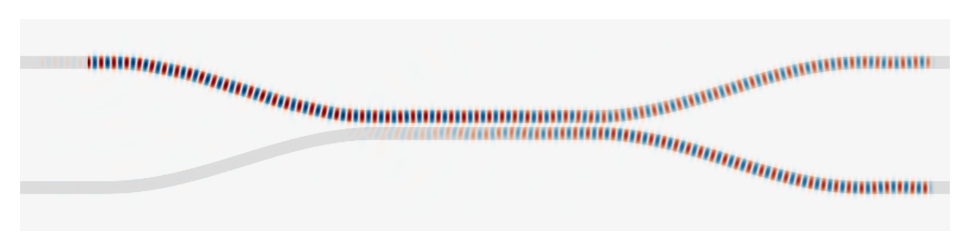

In [3]:
sim.reset_meep()

sources = [
    mp.EigenModeSource(
        src=mp.ContinuousSource(fcen, fwidth=df),
        size=src_vol.size,
        center=src_vol.center,
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
    )
]

sim = mp.Simulation(
    resolution=res,
    cell_size=cell.size,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
    geometry=geometry,
)

sim.run(
    until=400
)  # arbitrary long run time to ensure that fields have reached steady state

eps_data = sim.get_epsilon()
ez_data = numpy.real(sim.get_efield_z())

plt.figure(dpi=200)
plt.imshow(numpy.transpose(eps_data), interpolation="spline36", cmap="binary")
plt.imshow(
    numpy.flipud(numpy.transpose(ez_data)),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
plt.axis("off")
plt.show()

![](https://meep.readthedocs.io/en/latest/images/directional_coupler_field_profiles.png)

The field profiles confirm that for `d` of 0.06 μm (Figure 1), the input signal in Port 1 of the top branch is almost completely transferred to Port 4 of the bottom branch. For `d` of 0.13 μm (Figure 2), the input signal is split evenly between the two branches. Finally, for `d` of 0.30 μm (Figure 3), there is no longer any evanescent coupling and the signal remains completely in the top branch. Note the absence of the fields in the PML regions of Ports 3 and 4.